# TESTs

## Devices

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

## Test training model

Estimated train time : 0.0h 10.0m 48.0
--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.01
----------------------------------------
INFO - Step 100, rl-loss: 0.23385272920131683
INFO - Copied model parameters to target network.
INFO - Step 1100, rl-loss: 0.137152910232543954
INFO - Copied model parameters to target network.
INFO - Step 2100, rl-loss: 0.17178347706794746
INFO - Copied model parameters to target network.
INFO - Step 2340, rl-loss: 0.14448095858097076
----------------------------------------
  episode      |  100
  reward       |  -0.002
----------------------------------------
INFO - Step 3100, rl-loss: 0.186105608940124545
INFO - Copied model parameters to target network.
INFO - Step 4100, rl-loss: 0.131121858954429634
INFO - Copied model parameters to target network.
INFO - Step 4488, rl-loss: 0.106608450412750247
----------------------------------------
  episode      |  200
  reward       |  0.037
--------------

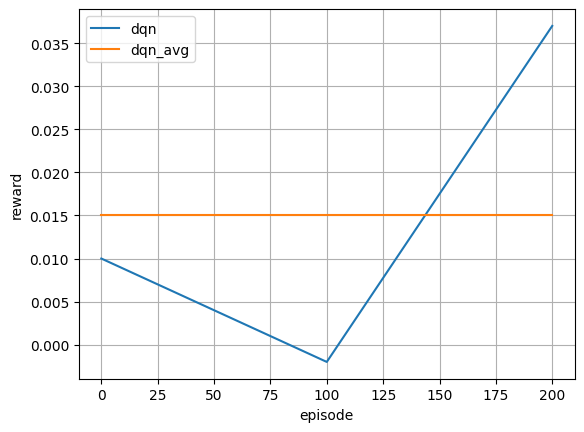

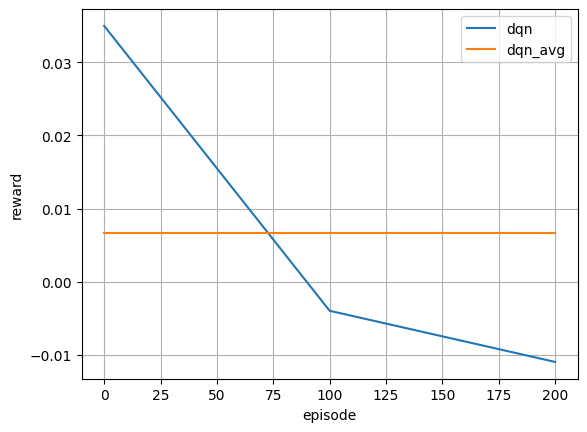

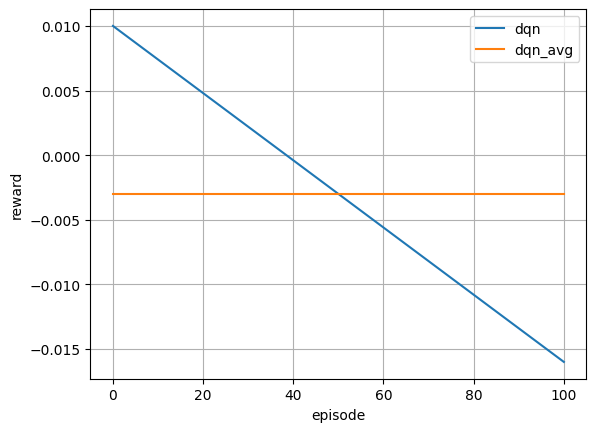

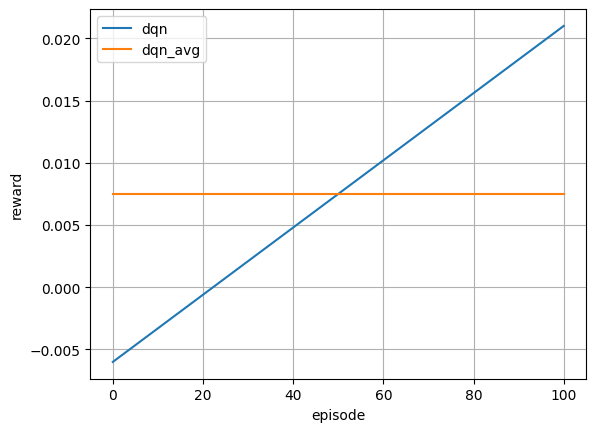

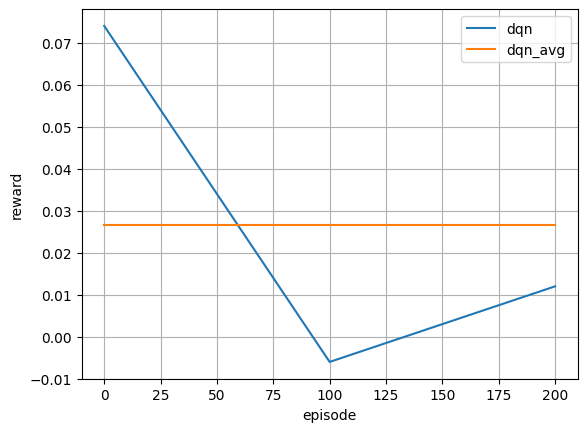

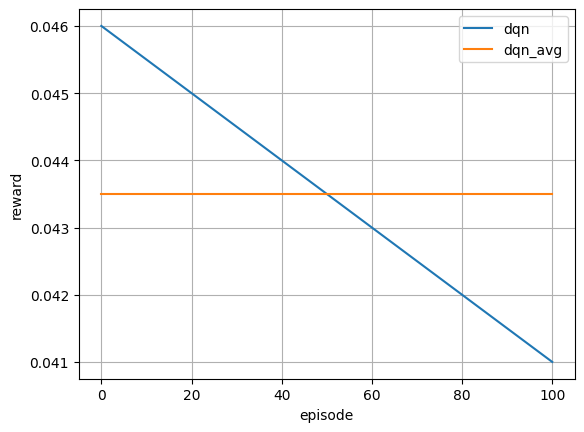

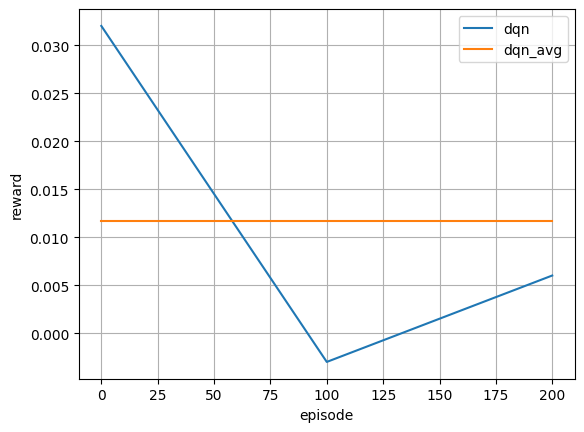

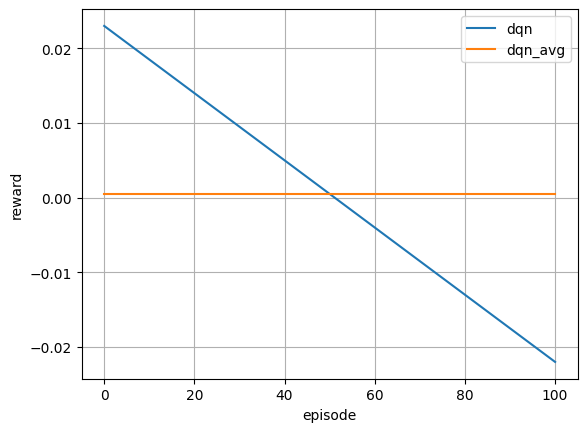

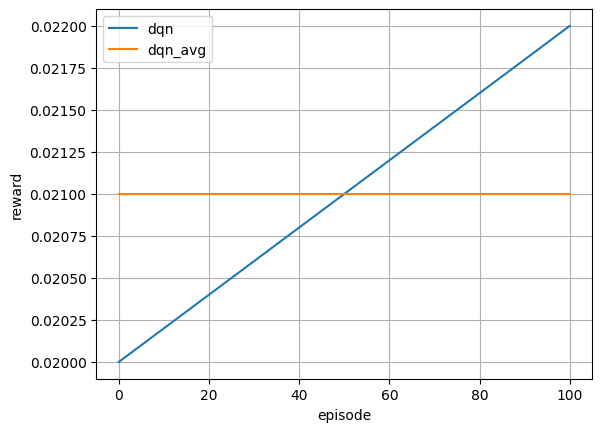

In [7]:
from agent_manager import train
import os

basic_size = 32
layer_architectures = ([1, 1],
                [2, 2],
                [3, 3],
                [1, 1, 1],
                [1, 1, 1, 1],
                [1, 2, 1],
                [2, 3, 2],
                [3, 2, 1],
                [1, 2, 3])

layer_architectures = tuple([e * basic_size for e in layer_type] for layer_type in layer_architectures)

resume = False

train_time={'heure': 1,
            'minute': 0,
            'seconde': 0}

train_time = train_time['heure'] * 3600 + train_time['minute'] * 60 + train_time['seconde']

estimated_train_time = train_time * 1.2 * len(layer_architectures)
print(f'Estimated train time : {estimated_train_time//3600}h {estimated_train_time%3600//60}m {estimated_train_time%3600%60}')

for i, layers in enumerate(layer_architectures):
    train(env_type='uno', algorithm='dqn', seed=42, num_episodes=5000, dir=f'./trained_models/local/{i}', mlp_layers=layers, resume_training=[None,'model.pth'][os.path.exists('./trained_models/local/{0}/model.pth') and resume], max_time=train_time) #


comparaison

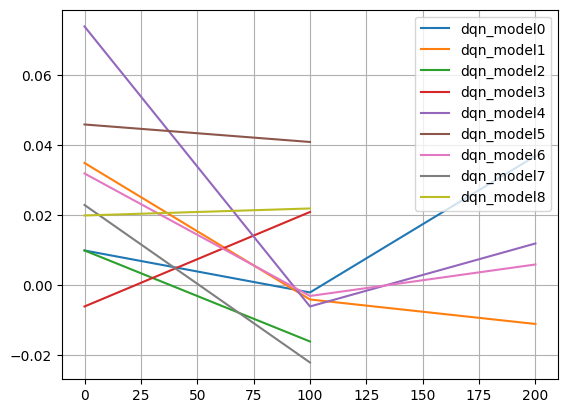

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

for i in range(len(layer_architectures)):
    dataset = pd.read_csv(f'./trained_models/local/{i}/performance.csv')

    plt.plot(dataset["episode"], dataset["reward"], label=f'dqn_model{i}')

plt.legend()
plt.grid()
plt.show()

## Evaluate some agents

In [9]:
from rlcard.models.uno_rule_models import UNORuleModelV1
from agent_manager.ruled import UNORuleModelV2
from rlcard.agents import RandomAgent
from rlcard import models
import torch
import rlcard
from agent_manager.utils import tournament, rank_agents

# Initialiser l'agent basé sur des règles
rule_agent_1 = UNORuleModelV1().agents[0]
rule_agent_2 = UNORuleModelV2().agents[0]

# Chargement d'un modèle DQN
load_checkpoint_path = "trained_models/local/0/model.pth"
dqn_agent=torch.load(load_checkpoint_path)

# Chargement d'un modèle CFR pré-entrainé
cfr_agent = models.load('leduc-holdem-cfr').agents[0]

# Initialisation d'un agent aléatoire
random_agent = RandomAgent(num_actions=61)

# Évaluer les agents sur "num_games" parties
dqn_agents = [torch.load(f"trained_models/local/{i}/model.pth")for i in range(5)]
agents = dqn_agents + [rule_agent_1, rule_agent_2, random_agent]

agents_names = [f"dqn_agent{i}" for i in range(5)] + ["rule_agent_1", "rule_agent_2", "random_agent", '???', '...']
num_games = 100

print("Classement des agents :")
for i, (name_index, score) in enumerate(rank_agents(agents, num_games=num_games)):
    print(f"Rank {i}: Agent {agents_names[name_index].center(max(map(len, agents_names)))} - Taux de victoires : {score:.2%}")

C:\Users\gcmpr\AppData\Local\Temp\ipykernel_1508\3950494287.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent=torch.load(load_checkpoint_path)
C:\Users\gcmpr\Ap

Classement des agents :
Rank 0: Agent rule_agent_1 - Taux de victoires : 55.71%
Rank 1: Agent rule_agent_2 - Taux de victoires : 53.43%
Rank 2: Agent  dqn_agent4  - Taux de victoires : 53.00%
Rank 3: Agent  dqn_agent2  - Taux de victoires : 48.14%
Rank 4: Agent  dqn_agent1  - Taux de victoires : 48.00%
Rank 5: Agent  dqn_agent0  - Taux de victoires : 47.57%
Rank 6: Agent  dqn_agent3  - Taux de victoires : 47.43%
Rank 7: Agent random_agent - Taux de victoires : 46.71%


# Remind :

```shell
python3.12 agent_manager --env_type uno --algorithm dqn --num_episode 500 --dir trained_model/local --resume_training model.pth
```